# Train Modelos - EEGSA - Guatemala
**Entranar los modelos y guardarlos para utilizarlos en la prediccion**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from  tqdm.notebook import  tqdm
%config IPCompleter.use_jedi = False
from sklearn.base import BaseEstimator, TransformerMixin
# from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# import statsmodels.api as sm
from itertools import groupby
warnings.filterwarnings('ignore')
import sys
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.base import ClassifierMixin
import joblib
import os
import sys
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,average_precision_score
import time

In [179]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [182]:
from src.preprocessing.preprocessing  import data_wrangling, ToDummy, TeEncoder, CardinalityReducer,build_feature_engeniering_pipeline
from src.modeling.simple_models import ChangeTrendPercentajeIdentifierWide,ConstantConsumptionClassifierWide
from src.modeling.supervided_models import LGBMModel, NNModel, LSTMNNModel, CATModel
from src.conf.config  import Config

## Configuracion

In [6]:
Config.init_config()

In [7]:
DATA_PATH = Config.get('workspace').get('data_path')
MODEL_PATH = Config.get('workspace').get('model_path')
periodo = Config.get('model').get('periodo')
cols_derivadas = pd.read_csv(f'{MODEL_PATH}features_by_const_boruta2_{periodo}.csv')['0'].tolist()
cols_consumo = [f'{i}_anterior' for i in range(periodo, 0, -1)]
cols_uc = Config.get('model').get('cols_uc')
tsfel_names_path = f'{MODEL_PATH}/'+Config.get('model').get('tsfel_names_path')

filename = Config.get('data').get('input_data')
hip_lgbm = Config.get('model').get('hip_lgbm') 
hip_cat = Config.get('model').get('hip_cat') 
hip_trend = Config.get('model').get('hip_trend') 
hip_const = Config.get('model').get('hip_const')
BATCH_SIZE = Config.get('model').get('hip_NN').get('batch_size') 
cols_for_model = cols_uc +cols_consumo+cols_derivadas
cols_comb_model = ['prob_cb','prob_lgbm','prob_ffn','prob_lstmffn','fraud_constante','fraud_trend']


name_model_fraud_lgbm = f'{MODEL_PATH}/model_fraud_lgbm.pkl'
name_model_fraud_cat = f'{MODEL_PATH}/model_fraud_cat.pkl'
name_model_fraud_nn = f'{MODEL_PATH}/model_fraud_nn.h5'
name_model_fraud_lstmnn = f'{MODEL_PATH}/model_fraud_lstmnn.h5'
name_pipe_features = f'{MODEL_PATH}/pipe_features.pkl'
name_pipe_spent = f'{MODEL_PATH}/pipe_spent.pkl'
name_model_fraud_comb  = f'{MODEL_PATH}/model_fraud_comb.pkl'

In [8]:
def load_datasets():
    df = pd.read_parquet(DATA_PATH+filename)
    return df

def preprocess_datasets(df):
    ## Esto deberia estar en el ETL
    # df.rename(columns={'id_usuario':'uc'}, inplace=True)
    df.rename(columns={'id':'index'}, inplace=True)
    df.rename(columns={'is_fraud':'target'}, inplace=True)
    pipe_feature_eng = build_feature_engeniering_pipeline(tsfel_names_path,num_periodos= periodo)
    df = data_wrangling(df,periodo)
    df = pipe_feature_eng.fit_transform(df, None)
    return df

def built_modelo_combinado(df):
    X_train_0 = df[df.target==0].copy()
    pos_size = len(df[df.target==1])
    X_train_0 = X_train_0.sample(int(pos_size*1))

    X_train = X_train_0.append(df[df.target==1]).sample(frac=1.0)
    y_train = X_train.target.copy()
    X_train = X_train[cols_comb_model]
    lr_comb_model = LogisticRegression(C=1.76, solver='liblinear')
    lr_comb_model.fit(X_train, y_train)
    return lr_comb_model

def save_model(model,file_name,is_pkl=True):
    if is_pkl:
        joblib.dump(model, file_name)
    else:
        model.save(file_name)

In [9]:
start_time = time.time()

In [239]:
DATA_PATH+filename

'../../data/clean_data/df_anonimizado_02-2023.parquet'

### Load Train Data Set

In [240]:
filename = 'df_anonimizado_02-2023.parquet'

In [244]:
%%time
df = load_datasets()
df.shape

CPU times: user 33.9 ms, sys: 21.7 ms, total: 55.6 ms
Wall time: 32.7 ms


(42500, 24)

In [53]:
from sklearn.preprocessing import MinMaxScaler
class MinMaxScalerRow(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        scaler = MinMaxScaler()
        return  scaler.fit_transform(X.T).T

### Division Train -  Test

In [54]:
df.sort_values('fecha_inspeccion', inplace=True)

In [55]:
obj_sacala_consumo = MinMaxScalerRow()
variables_consumo = [x for x in df.columns if '_anterior' in x]
df.loc[:,variables_consumo] = obj_sacala_consumo.fit_transform(df[variables_consumo])

In [56]:
#Particionar por fecha
df_train = df[df.fecha_inspeccion<'2017-08-01'].copy()
# y_train = df_train.target.copy()
# df_train = df_train.drop(columns=['target'])

df_val = df[(df.fecha_inspeccion>='2017-09-01')&(df.fecha_inspeccion<'2018-01-01')].copy()
# y_val = df_val.target.copy()
# df_val = df_val.drop(columns=['target'])


df_test = df[df.fecha_inspeccion>='2018-01-01'].copy()
# y_test = df_test.target.copy()
# df_test = df_test.drop(columns=['target'])


### Exploracion de los datos

In [57]:
def llenar_val_vacios_str(df, cols,  str_value):
    for x in cols:
        df.loc[:, x] = df[x].fillna(str_value)
    return df

def llenar_val_vacios_numeric(df, cols,  numeric_value):
    for x in cols:
        df.loc[:, x] = df[x].fillna(numeric_value)
    return df

def llenar_val_vacios_ciclo(df, cant_ciclos_validos):
    cols_consumo = [f'{i}_anterior' for i in range(cant_ciclos_validos, 0, -1)]
    
    df.loc[:, cols_consumo] = df.loc[:, cols_consumo].fillna(method='ffill', axis=1)
    df.loc[:, cols_consumo] = df.loc[:, cols_consumo].fillna(method='bfill', axis=1)
    return df

In [58]:
100*y_train.value_counts(normalize=True)

0   89.70636
1   10.29364
Name: target, dtype: float64

In [59]:
df_train.isnull().sum()

index                      0
12_anterior               30
11_anterior               28
10_anterior               19
9_anterior                18
8_anterior                17
7_anterior                11
6_anterior                17
5_anterior                29
4_anterior                41
3_anterior                49
2_anterior                62
1_anterior                71
zona_nivel_1               0
zona_nivel_2            1558
actividad               1558
seg_tarifa_nivel_1         0
seg_tarifa_nivel_2      1558
nivel_tension           1565
material_instalacion       0
cambios_seg_tarifa         0
medidor_interno            0
fecha_inspeccion           0
target                     0
dtype: int64

### Tratamiento de las variables de consumo

In [60]:
import tsfel
class TsfelVars(BaseEstimator, TransformerMixin):

    def __init__(self, features_names_path=None,num_periodos=12):
        self.num_periodos = num_periodos
        self.features_names_path = features_names_path

    def obtener_cols_anterior(self, num_cols=12):
        return [f'{i}_anterior' for i in range(num_cols,0, -1)]

    def extra_cols(self, df, domain, cols, window=12):
        cfg = tsfel.get_features_by_domain(domain)
        df_result = tsfel.time_series_features_extractor(cfg, df[cols].values,n_jobs=-1)
        df_result['index'] = df.index
        return df_result
    
    def compute_by_json(self,df, cols, window=12):
        cfg = tsfel.get_features_by_domain(json_path=self.features_names_path)
        df_result = tsfel.time_series_features_extractor(cfg, df[cols].values,n_jobs=-1)
        df_result['index'] = df.index
        return df_result

    def crear_all_tsfel(self, df):
        cols_anterior = self.obtener_cols_anterior(self.num_periodos)
        df_result_stat = self.extra_cols(df, "statistical", cols_anterior, window=self.num_periodos)
        df_result_temporal = self.extra_cols(df, "temporal", cols_anterior, window=self.num_periodos)
        # df_result_spectral = self.extra_cols(df, "spectral", cols_anterior, window=self.num_periodos)
        self.temp_vars = df_result_temporal.columns.tolist()
        self.temp_vars.remove('index')
        self.stat_vars = df_result_stat.columns.tolist()
        self.stat_vars.remove('index')
        # self.spec_vars = df_result_spectral.columns.tolist()
        # self.spec_vars.remove('index')
        return df_result_stat, df_result_temporal #, df_result_spectral

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.features_names_path != None:
            cols_anterior = self.obtener_cols_anterior(self.num_periodos)
            df_tsfel = self.compute_by_json(X, cols_anterior, window=self.num_periodos)
            X = X.merge(df_tsfel, on='index', how='left')
            
        else:
            # df_result_stat, df_result_temporal, df_result_spectral = self.crear_all_tsfel(X)
            df_result_stat, df_result_temporal = self.crear_all_tsfel(X)
            df_tsfel = pd.merge(df_result_stat, df_result_temporal, how='inner', on='index')
            # df_tsfel = pd.merge(df_tsfel, df_result_spectral, how='inner', on='index')
            X = X.merge(df_tsfel, on='index', how='left')

        return X
    

class ExtraVars(BaseEstimator, TransformerMixin):
    def __init__(self,num_periodos=3):
        self.num_periodos = num_periodos

    def fit(self, X, y=None):
        return self

    def obtener_cols_anterior(self, num_cols=12):
        return [f'{i}_anterior' for i in range(num_cols, 0, -1)]

    def transform(self, X):
        return self.create_vbles(X)

    def count_cero(self, x):
        return (x == 0.0).sum()

    def count_cero_seguidos(self, x):
        ceros_seguidos = 2
        consumo = x.values
        g = [[k, len(list(v))] for k, v in groupby(consumo)]
        g = [x for x in g if (x[0] == 0.0) & (x[1] >= ceros_seguidos)]
        if any(g):
            return sorted(g, reverse=True, key=lambda x: x[-1])[0][1]
        else:
            return 0

    def calc_slope(self, x):
        consumo = list(x.values)
        slope = np.polyfit(range(len(consumo)), consumo, 1)[0]
        return slope

    def create_vbles(self, df_total_super):
        # generar listado de cols de atras hacia delante i.e: ['3_anterior', '2_anterior', '1_anterior'], etc.
        cols_3_anterior = self.obtener_cols_anterior(num_cols=self.num_periodos)
        num_periodos_str = str(self.num_periodos)
        ## promedios
        df_total_super.loc[:, 'mean_' + num_periodos_str] = df_total_super[cols_3_anterior].mean(axis=1)
        ## Cantidad de ceros
        df_total_super.loc[:, 'cant_ceros_' + num_periodos_str] = df_total_super[cols_3_anterior].apply(self.count_cero,
                                                                                                        axis=1)
        df_total_super.loc[:, 'max_cant_ceros_seg_' + num_periodos_str] = df_total_super[cols_3_anterior].apply(
            self.count_cero_seguidos, axis=1)
        ## Slope
        df_total_super.loc[:, 'slope_' + num_periodos_str] = df_total_super[cols_3_anterior].apply(self.calc_slope,
                                                                                                   axis=1)
        ## Min, Max, STD, Varianza 3 periodos
        df_total_super.loc[:, 'min_cons' + num_periodos_str] = df_total_super[cols_3_anterior].min(axis=1)
        df_total_super.loc[:, 'max_cons' + num_periodos_str] = df_total_super[cols_3_anterior].max(axis=1)
        df_total_super.loc[:, 'std_cons' + num_periodos_str] = df_total_super[cols_3_anterior].std(axis=1)
        df_total_super.loc[:, 'var_cons' + num_periodos_str] = df_total_super[cols_3_anterior].var(axis=1)
        ## skewness y kurtosis 3 periodos
        df_total_super.loc[:, 'skew_cons' + num_periodos_str] = df_total_super[cols_3_anterior].skew(axis=1)
        if self.num_periodos > 3:
            df_total_super.loc[:, 'kurt_cons' + num_periodos_str] = df_total_super[cols_3_anterior].kurt(axis=1)

        return df_total_super

In [61]:
df_train = llenar_val_vacios_ciclo(df_train, 12)

In [62]:
variables_consumo = [x for x in df.columns if '_anterior' in x]
df_consumos = df_train[['index']+variables_consumo].head(10000)

In [63]:
pipe_feature_engeniering_consumo = Pipeline(
    [
        ("tsfel vars", TsfelVars(features_names_path=None,num_periodos= 12)),
        ("add vars3", ExtraVars(num_periodos=3)),
        ("add vars6", ExtraVars( num_periodos=6)),
        ("add vars12", ExtraVars(num_periodos=12)),

    ]
        )

In [64]:
df_features = pipe_feature_engeniering_consumo.fit_transform(df_consumos)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [65]:
df_features.head()

,index,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Histogram_0,0_Histogram_1,0_Histogram_2,0_Histogram_3,0_Histogram_4,0_Histogram_5,0_Histogram_6,0_Histogram_7,0_Histogram_8,0_Histogram_9,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Entropy,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,mean_3,cant_ceros_3,max_cant_ceros_seg_3,slope_3,min_cons3,max_cons3,std_cons3,var_cons3,skew_cons3,mean_6,cant_ceros_6,max_cant_ceros_seg_6,slope_6,min_cons6,max_cons6,std_cons6,var_cons6,skew_cons6,kurt_cons6,mean_12,cant_ceros_12,max_cant_ceros_seg_12,slope_12,min_cons12,max_cons12,std_cons12,var_cons12,skew_cons12,kurt_cons12
0,1857,0.57831,0.71687,0.68675,0.75904,1.00000,0.42169,0.00000,0.12048,0.18072,0.15663,0.11446,0.15060,2.00000,9.00000,0.11446,0.68675,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,0.00000,2.00000,3.00000,1.00000,0.55120,-1.24846,1.00000,0.40713,0.28665,0.30120,0.23193,0.00000,0.51490,0.39445,0.31522,0.09936,3.18141,0.04521,3.18141,0.02841,1.00000,0.16046,-0.03888,0.07229,0.03614,3.00000,0.00000,1.00000,3.00000,11.29257,-0.06919,1.76506,28.92193,2.00000,0.14056,0,0,-0.00301,0.11446,0.15663,0.02281,0.00052,-1.59710,0.12048,1,0,0.02031,0.00000,0.18072,0.06387,0.00408,-1.67666,3.27570,0.40713,1,0,-0.06919,0.00000,1.00000,0.32924,0.10840,0.45319,-1.25033
1,678,0.94118,0.64706,0.41176,0.44118,1.00000,0.38235,0.55882,0.67647,0.55882,0.64706,0.00000,0.47059,2.00000,9.00000,0.38235,0.64706,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,5.00000,3.00000,2.00000,0.22059,0.33521,1.00000,0.56127,0.18423,0.55882,0.11765,0.00000,0.61490,-0.24358,0.25114,0.06307,4.53720,0.06029,4.53720,0.04375,0.90702,0.30481,-0.04278,0.23529,0.02941,4.00000,0.00000,1.00000,3.00000,11.72042,-0.03342,3.35294,41.24725,2.00000,0.37255,1,0,-0.08824,0.00000,0.64706,0.33448,0.11188,-1.20566,0.48529,1,0,-0.06807,0.00000,0.67647,0.24870,0.06185,-1.99475,4.27939,0.56127,1,0,-0.03342,0.00000,1.00000,0.26231,0.06880,-0.27986,1.26595
2,4471,0.60989,0.70330,0.77473,1.00000,0.73626,0.00000,0.00000,0.00000,0.00000,0.36813,0.14286,0.00000,2.00000,9.00000,0.00000,0.70330,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,1.00000,0.00000,4.00000,1.00000,0.71154,-1.49562,1.00000,0.36126,0.33745,0.25549,0.25549,0.00000,0.51355,0.33115,0.36500,0.13322,3.16480,0.04030,3.16480,0.02619,0.73013,0.19331,-0.05544,0.14286,0.00000,0.00000,0.00000,1.00000,2.00000,11.40878,-0.07625,2.12637,28.77095,3.00000,0.17033,1,0,-0.18407,0.00000,0.36813,0.18560,0.03445,0.65151,0.08516,4,3,0.02276,0.00000,0.36813,0.14994,0.02248,1.81357,2.93577,0.36126,5,4,-0.07625,0.00000,1.00000,0.38123,0.14533,0.38046,-1.64305
3,7858,0.00000,0.18705,0.21583,0.42446,0.64748,0.47482,0.50360,0.40288,0.40288,0.29496,1.00000,0.92806,2.00000,9.00000,0.18705,0.50360,0.08333,0.16667,0.25000,0.33333,0.41667,0.50000,0.58333,0.66667,0.75000,0.83333,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2.00000,5.00000,1.00000,1.00000,0.26439,-0.34734,1.00000,0.45683,0.21163,0.41367,0.15827,0.00000,0.53486,0.53564,0.27817,0.07738,3.43295,0.05018,3.43295,0.08065,0.95351,0.16678,0.08437,0.10791,0.02878,2.00000,0.00

In [66]:
df_features['index'].nunique()

10000

### Seleccion de variables

In [67]:
def feature_selection_by_correlation(x_train, y_train, variables,method='pearson', th=0.9):
    print('Calculando Correlación Entre Variables')
    x_train['target'] = y_train
    df_corr = x_train[variables + ['target']].corr(method=method)
    # Buscar variables mas correlacionadas
    vars_to_drop_corr = []
    for x in variables:
        for y in variables:
            if x != y:
                c_value = df_corr[x][y]
                if np.abs(c_value) > th:
                    corr_x_t = np.abs(df_corr[x]['target'])
                    corr_y_t = np.abs(df_corr[y]['target'])
                    if corr_x_t > corr_y_t:
                        vars_to_drop_corr.append(y)
    x_train.drop(columns=['target'],inplace=True)
    print('Eliminando Variables Altamente Correlacionadas')
    variables = [x for x in variables if x not in vars_to_drop_corr]
    return variables

def feature_selection_by_constant(x_train, y_train, variables, th=0.99):
    num_rows = x_train.shape[0]
    allLabels = variables
    constant_per_feature = {label: x_train[label].value_counts().iloc[0]/num_rows for label in allLabels}
    variables_to_drop = [label for label in allLabels if constant_per_feature [label] > th]
    variables = [x for x in variables if x not in variables_to_drop]
    return variables

def feature_selection_by_boruta(X_train, y_train, N=10):
    d = {}
    X_train = X_train.copy()
    y_train = y_train.copy()
    for i in tqdm(range(N),total=N):
        # Hacemos eliminacion de variables por Boruta.
        X_train['random'] = [np.random.randn() for i in range(len(X_train))]
        rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=8)
        feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=i, perc=100)
        feat_selector.fit(X_train.values, y_train.values)
        ranking = pd.DataFrame({'col': X_train.columns, 'ranking': feat_selector.ranking_}).sort_values(
            ['ranking']).reset_index(drop=True)
        variables = ranking.head(ranking.loc[ranking.col == 'random'].index.values[0]).col.values
        d[i] = variables

    E = {}
    for i in d.keys():
        for j in d[i]:
            if j not in E.keys():
                E[j] = 1
            else:
                E[j] += 1

    variables = [k for k in E.keys() if E[k] >= N // 2]
    return variables

In [69]:
cols_for_feature_sel = [x for x in df_features.columns if x not in ['index'] + variables_consumo]
y_train = df_train.loc[df_features['index']].target

In [70]:
%%time
select_by_constant = feature_selection_by_constant(df_features, y_train, cols_for_feature_sel, th=0.99)
# pd.Series(sorted(select_by_constant)).to_csv('tmp/features_by_constante_12.csv', index=False)
print(f" # variables No constantes {len(select_by_constant)}")

 # variables No constantes 65
CPU times: user 99.4 ms, sys: 0 ns, total: 99.4 ms
Wall time: 98.5 ms


In [71]:
%%time
select_by_corr = feature_selection_by_correlation(df_features, y_train, select_by_constant,method='pearson', th=0.95)
# pd.Series(sorted(select_by_corr)).to_csv('tmp/features_by_corr_12.csv', index=False)
print(f" # variables No correlacionadas {len(select_by_corr)}")

Calculando Correlación Entre Variables
Eliminando Variables Altamente Correlacionadas
 # variables No correlacionadas 49
CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 165 ms


In [72]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [73]:
%%time
select_by_boruta = feature_selection_by_boruta(df_features[select_by_constant], y_train, N=5)
# pd.Series(sorted(select_by_boruta)).to_csv('tmp/features_by_const_boruta_12.csv', index=False)
print(f" # variables seleccionadas por Boruta : {len(select_by_boruta)}")

  0%|          | 0/5 [00:00<?, ?it/s]

 # variables seleccionadas por Boruta : 13
CPU times: user 12min 47s, sys: 12.9 s, total: 13min
Wall time: 2min 35s


In [74]:
select_by_boruta

['var_cons3',
 'std_cons3',
 '0_Sum absolute diff',
 '0_Median absolute diff',
 '0_Mean absolute diff',
 '0_Centroid',
 '0_Signal distance',
 'mean_3',
 'std_cons6',
 'max_cons3',
 '0_Median diff',
 'var_cons6',
 '0_Entropy']

### Columnas Categoricas

In [75]:
variables_categoricas = ['zona_nivel_2','actividad','material_instalacion','seg_tarifa_nivel_2']

In [77]:
df_train[variables_categoricas].head()

,zona_nivel_2,actividad,material_instalacion,seg_tarifa_nivel_2
1857,x1_AHFDFBDDDC,x2_FBHEEGGGAC,x5_BBDEGCIHEF,x4_FAAACEDCCB
678,x1_GFDECDCAEH,x2_AFFCADFBCD,x5_BBDEGCIHEF,x4_FAAACEDCCB
4471,None,None,x5_BBDEGCIHEF,None
7858,x1_DICECBEICE,x2_GHGDAACEIE,x5_EDBADCFGIF,x4_FAAACEDCCB
4292,x1_IDDGEHHFBF,x2_GHGDAACEIE,x5_CGECCBDIFH,x4_FAAACEDCCB


#### zona_nivel_2

In [78]:
df_train.zona_nivel_2.nunique()

38

In [79]:
100*df_train.groupby('zona_nivel_2').target.mean().head()

zona_nivel_2
x1_ABDBGBFBAA    6.72269
x1_ACCEFFFBFA   10.32609
x1_ACCFIEBHCA    2.76243
x1_AECCEFGICE    9.09091
x1_AHFDFBDDDC    3.48837
Name: target, dtype: float64

#### actividad

In [80]:
df_train.actividad.nunique()

209

In [81]:
100*df_train.groupby('actividad').target.mean().head()

actividad
x2_AAACFAEACB    0.00000
x2_AACBGGHAFC   33.33333
x2_AAFIAAABCC    0.00000
x2_AAGIACBDBH    7.69231
x2_AAHBFECHDI    0.00000
Name: target, dtype: float64

### material_instalacion

In [82]:
df_train.material_instalacion.nunique()

34

In [83]:
100*df_train.groupby('material_instalacion').target.mean().head()

material_instalacion
x5_AABCGGCDIB     0.00000
x5_AGAHBCEFEC     0.00000
x5_AIDDIGHDBI   100.00000
x5_BBCCDFFBBG     0.00000
x5_BBDEGCIHEF    11.10348
Name: target, dtype: float64

#### seg_tarifa_nivel_2

In [84]:
df_train.seg_tarifa_nivel_2.nunique()

23

In [85]:
100*df_train.groupby('seg_tarifa_nivel_2').target.mean().head()

seg_tarifa_nivel_2
x4_AAGIBEAAHG   0.00000
x4_AFIEGIBECI   0.00000
x4_AIDBGFIFII   0.84034
x4_CAHGGDBGEH   0.00000
x4_CBCECGEIGF   0.00000
Name: target, dtype: float64

### Pipeline de preprocesamientos

In [86]:
variables_categoricas = ['zona_nivel_2','actividad','material_instalacion','seg_tarifa_nivel_2']

In [95]:
# Actividad 
pipe_actividad = Pipeline([
            ('cardinality_reducer', CardinalityReducer(threshold=0.001)),
            ('a_dummy',ToDummy(['actividad']))
        ])

# Segmento Tarifa
pipe_tarifa = Pipeline([
            ('cardinality_reducer', CardinalityReducer(threshold=0.001)),
            ('tarifa_te',TeEncoder(['seg_tarifa_nivel_2'],w=20))
        ])

t_features = [
    ('zona_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['zona_nivel_2']),
    ('material_isntalacion_te', TeEncoder(['material_instalacion'],w=10), ['material_instalacion']),
    ('actividad_cr_dummy', pipe_actividad, ['actividad_economica']),
    ('tarifa_cr_te', pipe_tarifa, ['seg_tarifa_nivel_2']),
    ]

preprocessor = ColumnTransformer(transformers= t_features,remainder='passthrough')

### Train models

In [88]:
#Particionar por fecha
y_train = df_train.target.copy()
df_train = df_train.drop(columns=['target'])

y_val = df_val.target.copy()
df_val = df_val.drop(columns=['target'])


y_test = df_test.target.copy()
df_test = df_test.drop(columns=['target'])

In [90]:
df_train = pipe_feature_engeniering_consumo.fit_transform(df_train)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [89]:
df_val = pipe_feature_engeniering_consumo.fit_transform(df_val)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [91]:
df_test = pipe_feature_engeniering_consumo.fit_transform(df_test)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [151]:
y_train.value_counts(normalize=False)

0    12383
1     1356
Name: target, dtype: int64

In [219]:
cols_for_model = variables_categoricas+cols_consumo+select_by_corr

In [220]:
sampling_th = 0.4
param_imb_method = 'under'

In [221]:
%%time
train_lgbm_model = LGBMModel(cols_for_model,
                             hyperparams=None,
                             search_hip=True,
                             sampling_th = sampling_th,
                             preprocesor_num=4,
                             sampling_method=param_imb_method)
lgbm_model = train_lgbm_model.train(df_train,y_train,df_val, y_val)


Best score reached: 0.6976470174518922 with params: {'lgbmclassifier__colsample_bytree': 0.5724726792874275, 'lgbmclassifier__learning_rate': 0.09042371348412374, 'lgbmclassifier__max_bin': 128, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__min_child_samples': 240, 'lgbmclassifier__min_child_weight': 0.001, 'lgbmclassifier__num_leaves': 40, 'lgbmclassifier__reg_alpha': 5, 'lgbmclassifier__reg_lambda': 0.001, 'lgbmclassifier__scale_pos_weight': 5, 'lgbmclassifier__subsample': 0.8087445946527063, 'lgbmclassifier__subsample_freq': 11} 
CPU times: user 5.73 s, sys: 134 ms, total: 5.86 s
Wall time: 4.78 s


In [222]:
y_pred_test_lgbm = lgbm_model.predict_proba(df_test[cols_for_model])[:,1]

In [223]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lgbm))

AUC Test:  0.767


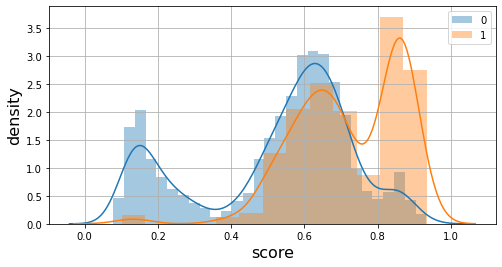

In [224]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lgbm[y_test==0], label='0')
sns.distplot(y_pred_test_lgbm[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

In [237]:
%%time
train_cat_model = CATModel(cols_for_model,hyperparams=None,search_hip=True,sampling_th = sampling_th,preprocesor_num = 4,sampling_method=param_imb_method)
cb_model = train_cat_model.train(df_train,y_train,df_val, y_val)

TypeError: must be real number, not NoneType

In [227]:
%%time
features_names = variables_categoricas + select_by_boruta
spents_names = cols_consumo
lstm_nn_model = LSTMNNModel(features_names,spents_names,sampling_th = sampling_th,preprocesor_num = 4,sampling_method=param_imb_method)
lstm_rnn_model,pipe_features,pipe_spent = lstm_nn_model.train(df_train,y_train)

Restoring model weights from the end of the best epoch.
Epoch 00368: early stopping
CPU times: user 16min 37s, sys: 13min 46s, total: 30min 24s
Wall time: 2min 28s


In [228]:
X_test_features = pipe_features.transform(df_test[features_names])
X_test_spents = pipe_spent.transform(df_test[spents_names])
X_test_spents = X_test_spents.reshape((X_test_spents.shape[0],periodo,1))

In [230]:
y_pred_test_lstm_rnn = lstm_rnn_model.predict([X_test_spents, X_test_features],batch_size=lstm_nn_model.BATCH_SIZE)[:,0]
# resulado_final[f'{param_imb_method}-lstm-ffn'] = y_pred_test_lstm_rnn

In [233]:
pd.Series(y_pred_test_lstm_rnn).isnull().sum()

35

In [231]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lstm_rnn))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [60]:
cfg = tsfel.get_features_by_domain()

x = tsfel.time_series_features_extractor(cfg, df_consumos[variables_consumo].head().values,fs=1,n_jobs=-1)

*** Feature extraction started ***



*** Feature extraction finished ***


In [61]:
x.shape

(5, 141)

In [55]:
num_6 = [f'{i}_anterior' for i in range(6, 0, -1)]

x1 = tsfel.time_series_features_extractor(cfg, df_consumos[num_6].head(20).values,window_size=6,n_jobs=-1)

*** Feature extraction started ***


ValueError: Input signal must have a length >= n_coeff

Process ForkPoolWorker-140:
Process ForkPoolWorker-132:
Process ForkPoolWorker-129:
Process ForkPoolWorker-142:
Traceback (most recent call last):
Process ForkPoolWorker-143:
Process ForkPoolWorker-139:
Process ForkPoolWorker-138:
Process ForkPoolWorker-135:
Process ForkPoolWorker-137:
Process ForkPoolWorker-131:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-136:
Process ForkPoolWorker-134:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-133:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.r

In [45]:
x.shape

(5, 141)

In [41]:
tsfel.time_series_features_extractor()

Signature:
tsfel.time_series_features_extractor(
    dict_features,
    signal_windows,
    fs=None,
    verbose=1,
    **kwargs,
)
Docstring:
Extraction of time series features.

Parameters
----------
dict_features : dict
    Dictionary with features
signal_windows: list
    Input from which features are computed, window
fs : int or None
    Sampling frequency
verbose : int
    Verbosity mode. 0 = silent, 1 = progress bar.
    (0 or 1 (Default))
\**kwargs:
See below:
    * *window_size* (``int``) --
        Window size in number of samples
        (default: ``100``)

    * *overlap* (``float``) --
        Overlap between 0 and 1
        (default: ``0``)

    * *features_path* (``string``) --
        Directory of script with personal features

    * *header_names* (``list or array``) --
        Names of each column window

    * *n_jobs* (``int``) --
        The number of jobs to run in parallel. ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means 

In [39]:
tsfel.get_features_by_domain?

Signature: tsfel.get_features_by_domain(domain=None, json_path=None)
Docstring:
Creates a dictionary with the features settings by domain.

Parameters
----------
domain : string
    Available domains: "statistical"; "spectral"; "temporal"
    If domain equals None, then the features settings from all domains are returned.
json_path : string
    Directory of json file. Default: package features.json directory

Returns
-------
Dict
    Dictionary with the features settings
File:      /usr/local/lib/python3.6/site-packages/tsfel/feature_extraction/features_settings.py
Type:      function


### Preprocess Data

In [16]:
%%time
df = preprocess_datasets(df)

self.read False


AttributeError: 'DataFrame' object has no attribute 'uc'

### Train

In [14]:
df = df.sample(frac=1.0)
df_train, df_val, y_train, y_val = train_test_split(df,df.target, test_size=0.2, random_state=42)

In [15]:
lgbm_model = LGBMModel(cols_for_model,hip_lgbm)
lgbm_final_model = lgbm_model.train(df_train,y_train)

In [16]:
cat_model = CATModel(cols_for_model,hip_cat)
cat_final_model = cat_model.train(df_train,y_train)

In [17]:
features_names = cols_uc + cols_derivadas
spents_names = cols_consumo
nn_model = NNModel(features_names,spents_names)
rnn_final_model,pipe_features,pipe_spent = nn_model.train(df_train,y_train)

2022-12-11 20:19:18.833133: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-11 20:19:18.833184: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-11 20:19:18.833207: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (49434f55fd6e): /proc/driver/nvidia/version does not exist
2022-12-11 20:19:18.833479: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-11 20:19:18.861904: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400010000 Hz
2022-12-11 20:19:18.863409: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557a4b32b860 initialized for platform Host (this does not guarantee tha

Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping


In [18]:
features_names = cols_uc + cols_derivadas
spents_names = cols_consumo
lstm_nn_model = LSTMNNModel(features_names,spents_names)
lstm_rnn_final_model,pipe_features,pipe_spent = lstm_nn_model.train(df_train,y_train)

Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping


In [19]:
trend_perc_model = ChangeTrendPercentajeIdentifierWide(**hip_trend)
const_model = ConstantConsumptionClassifierWide(**hip_const)

In [20]:
df_val['prob_lgbm'] = lgbm_final_model.predict_proba(df_val[cols_for_model])[:,1]
df_val['prob_cb'] = cat_final_model.predict_proba(df_val[cols_for_model])[:,1]

X_features = pipe_features.transform(df_val[features_names])
X_spents = pipe_spent.transform(df_val[spents_names])
X = np.concatenate([X_features,X_spents],axis=1)
df_val['prob_ffn'] = rnn_final_model.predict(X, batch_size=BATCH_SIZE)[:,0]

X_features = pipe_features.transform(df_val[features_names])
X_spents = pipe_spent.transform(df_val[spents_names])
X_spents = X_spents.reshape((X_spents.shape[0],periodo,1))
df_val['prob_lstmffn'] = lstm_rnn_final_model.predict([X_spents, X_features],batch_size=BATCH_SIZE)[:,0]

pred_tc = trend_perc_model.predict(df_val)
df_val['fraud_trend'] = pred_tc.is_fraud_trend_perc

pred_cm = const_model.predict(df_val[cols_consumo])
df_val['fraud_constante'] = pred_cm

In [21]:
lr_comb_model = built_modelo_combinado(df_val)

In [22]:
save_model(lgbm_final_model,name_model_fraud_lgbm)
save_model(cat_final_model,name_model_fraud_cat)
save_model(pipe_features,name_pipe_features)
save_model(pipe_spent,name_pipe_spent)
save_model(rnn_final_model,name_model_fraud_nn,False)
save_model(lstm_rnn_final_model,name_model_fraud_lstmnn,False)
save_model(lr_comb_model,name_model_fraud_comb)

In [23]:
y_pred_comb = lr_comb_model.predict_proba(df_val[cols_comb_model])[:,1]
df_val['prob_final'] = y_pred_comb

In [24]:
print("AUC Test:  %.3f" %  roc_auc_score(y_val,y_pred_comb))
print("AP Test:  %.3f" %  average_precision_score(y_val,y_pred_comb,average='weighted'))

AUC Test:  0.538
AP Test:  0.026


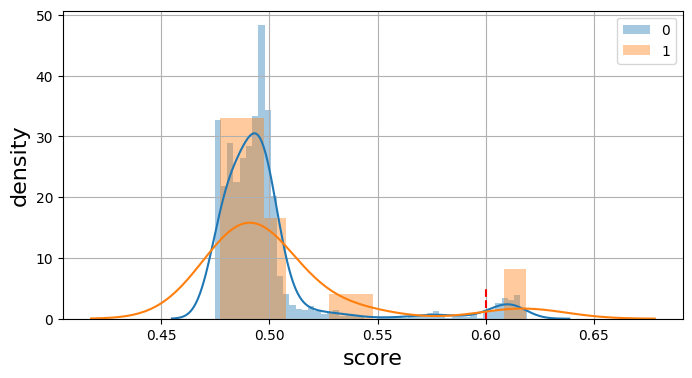

In [25]:
plt.figure(figsize=(8,4))
sns.distplot(df_val[df_val.target==0].prob_final, label='0')
sns.distplot(df_val[df_val.target==1].prob_final, label='1')
plt.vlines(0.6, ymin=0, ymax=5, color='red', linestyles='dashed')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

In [46]:
print("Fin")
print("--- %s seconds ---" % (time.time() - start_time))

Fin
